In [271]:
import dask
from dask import delayed
import dockermap
from functools import partial
from dockermap.shortcuts import _format_cmd
from collections import OrderedDict
from dockermap.api import DockerClientWrapper
from pathlib import Path
from dask.diagnostics import ProgressBar
from dockermap.api import DockerContext
from functools import wraps
from operator import methodcaller
from textwrap import indent, dedent
from dask.diagnostics import ProgressBar

In [ ]:
import logging
logging.basicConfig(level=logging.DEBUG)

## Docker Build Tool

We're going to use buildbot's docker-latent worker to properly isolate the builds. 
Otherwise We'd need to manually install all the required dependencies over a variaty of environments, which would be really complicated, even with a config management tool.

Thanks to docker We can have pre-built images for different [architecture](https://github.com/docker-library/official-images#architectures-other-than-amd64), operating system and environment combinations, for example `amd64-windows-conda`. 

With this setup the build matrix quickly grows, which requires a way to define the worker docker images in a reusable and maintainable fashion. There are a couple of solutions, mostly yaml and jinja based ones to generate dependent dockerfiles and build image hierarchies, the most notable one is [DockerMake](https://github.com/avirshup/DockerMake). I've created a [prototype](https://gist.github.com/kszucs/248389d473b1b58646281515d521434f) with it, but found multiple isses:

- it doesn't handle the dependency tree properly (it was trying to build descendant images with missing parents)
- no official jinja support (I've created a patch though)
- no concurrency support (which is a "should have")


### DockerImage abstraction over DockerFile provided by docker-map

[Docker-map](https://github.com/merll/docker-map) is a wrapper around [docker-py](https://github.com/docker/docker-py).

In [272]:
class DockerFile(dockermap.api.DockerFile):
    
    def __str__(self):
        return self.fileobj.getvalue().decode('utf-8')
    

class DockerImage:
    
    def __init__(self, tag, base, steps=tuple(), extra_tags=tuple()):
        if isinstance(base, DockerImage):
            base = base.tag
        elif not isinstance(base, str):
            raise TypeError('`tag` argument must be an instance of DockerImage or str')

        if not isinstance(tag, str):
            raise TypeError('`tag` argument must be an instance of str')

        if not isinstance(steps, (tuple, list)):
            raise TypeError('`steps` argument must be an instance of list or tuple')
        elif not all(callable(step) for step in steps):
            raise TypeError('each `step` must be a callable, use `run` function')
        
        if not isinstance(extra_tags, (tuple, list)):
            raise TypeError('`extra_tags` argument must be an instance of list or tuple')
        elif not all(isinstance(tag, str) for tag in extra_tags):
            raise TypeError('each `extra_tag` must be an instance of str')
            
        self.tag = tag
        self.base = base
        self.steps = steps
        self.extra_tags = extra_tags
        
    def __repr__(self):
        return f'<DockerImage: {self.tag} at {id(self)}>'
        
    @property
    def dockerfile(self):
        df = DockerFile(self.base)
        for callback in self.steps:
            callback(df)
        df.finalize()
        return df
    
    @property
    def tags(self):
        """All tags of the image"""
        return (self.tag,) + tuple(self.extra_tags)
    
    def save_dockerfile(self, directory):
        path = Path(directory) / f'{self.tag}.dockerfile'
        self.dockerfile.save(path)
            
    def build(self, client=None, **kwargs):
        if client is None:
            client = DockerClientWrapper()
            
        # wrap it in a try catch and serialize the failing dockerfile
        return client.build_from_file(self.dockerfile, self.tag, 
                                      add_tags=self.extra_tags, **kwargs)
        

### Utility functions - similar to docker-map's shortcuts

In [273]:
# already provided commands
from dockermap.shortcuts import adduser, chmod 

In [275]:
_tab = ' ' * 4


@wraps(DockerFile.add_file, ('__doc__',))
def ADD(*args, **kwargs):
    return methodcaller('add_file', *args, **kwargs)


@wraps(DockerFile.run, ('__doc__',))
def RUN(*args):
    return methodcaller('run', *args)


def ENV(**kwargs):
    args = tuple(map("=".join, kwargs.items()))
    args = indent(" \\\n".join(args), _tab).lstrip()
    return methodcaller('prefix', 'ENV', args)


def CMD(command):
    return lambda df: setattr(df, 'command', command)
    
    
def WORKDIR(workdir):
    return lambda df: setattr(df, 'command_workdir', workdir)
    
    
def USER(username):
    return lambda df: setattr(df, 'command_user', username)


def SHELL(shell):
    return lambda df: setattr(df, 'shell', shell)
    

def apt(*packages):
    """Generates apt install command"""
    template = dedent("""
        apt update -y -q && \\
        apt install -y -q \\
        {} && \\
        rm -rf /var/lib/apt/lists/*
    """)
    args = indent(' \\\n'.join(packages), _tab)
    cmd = indent(template.format(args), _tab)
    return cmd.lstrip()


def apk(*packages):
    """Generates apk install command"""
    template = dedent("""
        apk add --no-cache -q \\
        {}
    """)
    args = indent(' \\\n'.join(packages), _tab)
    cmd = indent(template.format(args), _tab)
    return cmd.lstrip()


def pip(*packages, files=tuple()):
    """Generates pip install command"""
    template = dedent("""
        pip install \\
        {}
    """)
    args = tuple(f'-r {f}' for f in files) + packages
    args = indent(' \\\n'.join(args), _tab)
    cmd = indent(template.format(args), _tab)
    return cmd.lstrip()


def conda(*packages, files=tuple()):
    """Generate conda install command"""
    template = dedent("""
        conda install -y -q \\
        {} && \\
        conda clean -q --all
    """)
    args = tuple(f'--file {f}' for f in files) + packages
    args = indent(' \\\n'.join(args), _tab)
    cmd = indent(template.format(args), _tab)
    return cmd.lstrip()

### Define images for Ubuntu, Alpine and Conda

In [276]:
ubuntu_pkgs = [
    'autoconf',
    'build-essential',
    'cmake',
    'libboost-dev',
    'libboost-filesystem-dev',
    'libboost-regex-dev',
    'libboost-system-dev',
    'python',
    'python-pip',
    'bison',
    'flex'
]

alpine_pkgs = [
    'autoconf',
    'bash',
    'bison',
    'boost-dev',
    'cmake',
    'flex',
    'g++',
    'gcc',
    'git',
    'gzip',
    'make',
    'musl-dev',
    'ninja',
    'wget',
    'zlib-dev',
    'python-dev'
]

In [277]:
## it's quiet easy to parallelize the build of the image hierarchy via dask,
## just replace DockerImage with its dask.delayed alternative:

DelayedDockerImage = delayed(DockerImage)

In [278]:
from dockermap.shortcuts import mkdir, adduser, chown

In [279]:
images = []
envs = Path('envs')
scripts = Path('scripts')


worker_steps = [
    RUN(pip('buildbot-worker')),
    RUN(mkdir('/buildbot')),
    ADD('buildbot.tac', '/buildbot/buildbot.tac'),
    WORKDIR('/buildbot'),
    CMD('twistd --pidfile= -ny buildbot.tac')
]

for arch in ['amd64', 'arm64v8', 'ppc64le']:
    # UBUNTU
    for version in ['16.04', '18.04', '18.10']:
        prefix = f'{arch}-ubuntu-{version}'
        base = f'{arch}/ubuntu:{version}'
        
        cpp = DelayedDockerImage(f'{prefix}-cpp', base=base, steps=[
            RUN(apt(*ubuntu_pkgs))
        ] + worker_steps)
        
        python = DelayedDockerImage(f'{prefix}-python', base=cpp, steps=[
            ADD(envs / 'requirements.txt'),
            RUN(pip(files=['requirements.txt']))
        ])
        
        images.extend([cpp, python])
        
    # ALPINE
    for version in ['3.8', '3.9']:
        prefix = f'{arch}-alpine-{version}'
        base = f'{arch}/alpine:{version}'
        
        cpp = DelayedDockerImage(f'{prefix}-cpp', base=base, steps=[
            RUN(apk(*alpine_pkgs)),
            RUN('python -m ensurepip'),
        ] + worker_steps)
        
        python = DelayedDockerImage(f'{prefix}-python', base=cpp, steps=[
            ADD(envs / 'requirements.txt'),
            RUN(pip(files=['requirements.txt']))
        ])
        
        images.extend([cpp, python])
        
# CONDA
for arch in ['amd64']:
    base = f'{arch}/ubuntu:18.04'
    
    cpp = DelayedDockerImage(f'{arch}-conda-cpp', base=base, steps=[ 
        RUN(apt('wget')),
        # install miniconda
        ENV(PATH='/opt/conda/bin:$PATH'),
        ADD(scripts / 'install_conda.sh'),
        RUN('/install_conda.sh', arch, '/opt/conda'),
        # install cpp dependencies
        ADD(envs / 'conda-linux.txt'),
        ADD(envs / 'conda-cpp.txt'),
        RUN(conda('twisted', files=['conda-linux.txt', 
                                    'conda-cpp.txt']))
    ] + worker_steps)
    
    python = DelayedDockerImage(f'{arch}-conda-python', base=cpp, steps=[
        ADD(envs / 'conda-python.txt'),
        RUN(conda(files=['conda-python.txt']))
    ])
    
    images.extend([cpp, python])

### Build the Images

In [280]:
dask.compute(*[img.tag for img in images])

('amd64-ubuntu-16.04-cpp',
 'amd64-ubuntu-16.04-python',
 'amd64-ubuntu-18.04-cpp',
 'amd64-ubuntu-18.04-python',
 'amd64-ubuntu-18.10-cpp',
 'amd64-ubuntu-18.10-python',
 'amd64-alpine-3.8-cpp',
 'amd64-alpine-3.8-python',
 'amd64-alpine-3.9-cpp',
 'amd64-alpine-3.9-python',
 'arm64v8-ubuntu-16.04-cpp',
 'arm64v8-ubuntu-16.04-python',
 'arm64v8-ubuntu-18.04-cpp',
 'arm64v8-ubuntu-18.04-python',
 'arm64v8-ubuntu-18.10-cpp',
 'arm64v8-ubuntu-18.10-python',
 'arm64v8-alpine-3.8-cpp',
 'arm64v8-alpine-3.8-python',
 'arm64v8-alpine-3.9-cpp',
 'arm64v8-alpine-3.9-python',
 'ppc64le-ubuntu-16.04-cpp',
 'ppc64le-ubuntu-16.04-python',
 'ppc64le-ubuntu-18.04-cpp',
 'ppc64le-ubuntu-18.04-python',
 'ppc64le-ubuntu-18.10-cpp',
 'ppc64le-ubuntu-18.10-python',
 'ppc64le-alpine-3.8-cpp',
 'ppc64le-alpine-3.8-python',
 'ppc64le-alpine-3.9-cpp',
 'ppc64le-alpine-3.9-python',
 'amd64-conda-cpp',
 'amd64-conda-python')

In [281]:
# serialize the dockerfiles to ./dockerfiles
_ = dask.compute([img.save_dockerfile('dockerfiles') for img in images])

In [282]:
# lazy image builds
builds = [img.build() for img in images]
builds

[Delayed('build-4b1e4196-7d71-49c8-90ee-d08e399d3532'),
 Delayed('build-e7c22e58-74fd-4def-8269-2cbc77cf04f8'),
 Delayed('build-715e300f-8155-45f1-8055-2ef7825bf9c7'),
 Delayed('build-a399a309-8c77-43c5-863e-1af60f41eb69'),
 Delayed('build-fe8f61b1-dfdb-46ec-b0be-fd907e4e9fe4'),
 Delayed('build-0bf65d84-1ae9-4cd7-bdf1-ab07a878fe67'),
 Delayed('build-6628e30e-687d-4914-ae36-9b5c7f886653'),
 Delayed('build-3e34ddbb-2d18-4a28-a27e-2f662b76d97f'),
 Delayed('build-24cf227b-a743-489e-947c-aee58bd13c82'),
 Delayed('build-df6da66e-9462-401b-b4df-a6918fc83319'),
 Delayed('build-f909f65b-5ee3-48f6-becc-d696c6ca337e'),
 Delayed('build-ff4a0625-241f-4297-b241-4ba64e7ddbc2'),
 Delayed('build-796563c1-2974-47fa-a8f0-06d65aed538e'),
 Delayed('build-98d388e5-c9d9-44bf-9f6a-5da3543f7730'),
 Delayed('build-6fa1c714-0021-457f-807d-9bb082b91856'),
 Delayed('build-59403b6e-38fc-4140-9ab5-7d57c78f5a66'),
 Delayed('build-3d97f8c5-0409-4706-b35a-a85b2068ec46'),
 Delayed('build-7aba7af4-b84e-47b3-a705-9e0447a4

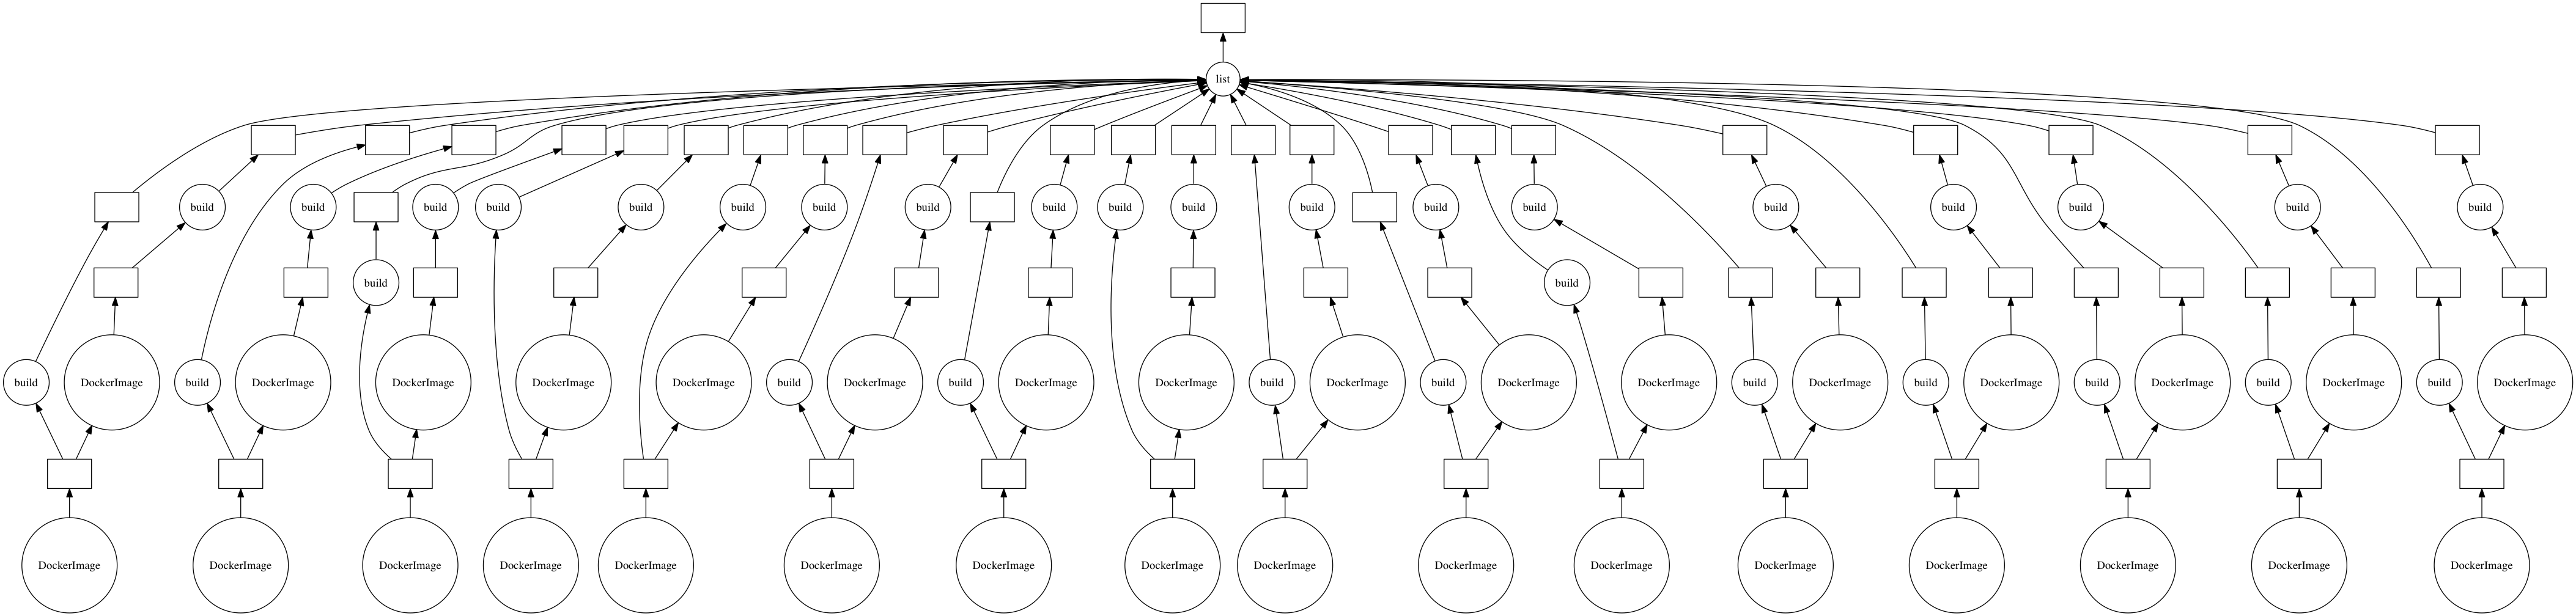

In [283]:
# vialize the hierarchy and the build order
collect = delayed(list)
result = collect(builds)
result.visualize()

In [ ]:
# execute the build sequentially without dask
imgs = dask.compute(*images)
for img in imgs:
    print(img.tag)
    img.build()

In [ ]:
# execute the builds with dask sequentially
with ProgressBar():
    dask.compute(result, scheduler=dask.local.get_sync)

In [ ]:
# execute the builds with dask concurrently
with ProgressBar():
    result.compute()